# Permutation Importance

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import os
import random
import dill
import pickle
from tabulate import tabulate
import matplotlib.pyplot as plt


import sys

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb

try:
  from catboost import CatBoostClassifier
except:
  !pip install catboost
  from catboost import CatBoostClassifier

import time
from datetime import timedelta

from sklearn.inspection import permutation_importance

In [2]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

if IN_COLAB:  
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)
  # connect your colab with the drive
  drive.mount(mount)

 # Switch to the directory on the Google Drive that you want to use
  import os
  path_to_repo = mount + "/My Drive/MIMIC-III Text Mining/mimim_iii_readmission"

else:
   path_to_repo = os.path.dirname(os.getcwd())

  
print(path_to_repo)

C:\Users\luca9\Documents\MIMIC-III Text Mining\mimim_iii_readmission


In [3]:
# PARAMETERS

session_seed = 42 # set seed for our session
include_val = False # set to True if we want to also create a validation set
tune_models = False # set to True if we want to perform parameter tuning

icu_stays = True # set to TRUE if we want to have only ICU stays
lemmatize = True # set to false if we want to do stemming
lemma_tag = str(np.where(lemmatize, "_lemma",""))
heavier_proc = True # if we want a heavier processing
if heavier_proc:
    heavier_tag = '_heavier'
else:
    heavier_tag = ''
    
spacy = True
if spacy: lemma_tag = str(np.where(lemmatize, "_lemma_spacy",""))

seed_tag = f'_{session_seed}'

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

random.seed(session_seed)

med_7 = False # set to True if we want to use our Med7 preprocessing

if med_7:
    med_tag = "_med7"
else:
    med_tag = ''
    
feat_select = False # select True if we want to use Lasso as a feature selection method

if feat_select:
    feat_tag = "_featselect"
else:
    feat_tag = ''
    
expanded_def = True # set to True if we want to consider future readmissions and avoid using CMS 

if icu_stays == True:
    icu_folder = 'icu_only'
    if expanded_def:
        icu_folder = 'expanded'
else:
    icu_folder = 'all_hosp'

scoring = 'roc_auc' # what score should we use for permutation importance

In [4]:
path_to_data = os.path.join(path_to_repo, "data", icu_folder,"")
print(path_to_data)

C:\Users\luca9\Documents\MIMIC-III Text Mining\mimim_iii_readmission\data\expanded\


In [5]:
path_to_processed = os.path.join(path_to_data,"processed","")
os.makedirs(path_to_processed, exist_ok=True) # we create the directory if it does not exist
print(path_to_processed)

C:\Users\luca9\Documents\MIMIC-III Text Mining\mimim_iii_readmission\data\expanded\processed\


In [6]:
path_to_models = os.path.join(path_to_data,"models","")
os.makedirs(path_to_models, exist_ok=True) # we create the directory if it does not exist
print(path_to_models)

C:\Users\luca9\Documents\MIMIC-III Text Mining\mimim_iii_readmission\data\expanded\models\


In [7]:
path_to_figures = os.path.join(path_to_data,"figures","")
os.makedirs(path_to_figures, exist_ok=True) # we create the directory if it does not exist
print(path_to_figures)

C:\Users\luca9\Documents\MIMIC-III Text Mining\mimim_iii_readmission\data\expanded\figures\


In [8]:
def load_datasets(method, include_val = True, target = False):
    """
    Function to load train, test and validation set based on the chosen method
    method: string for the processing method we want to load
    include_diag: if we want to load the dataframes with the diagnosis text, default True
    include_test: if we want to load also the test set, default True
    target: if we are importing our target variables
    """
    global path_to_processed
    if target == True: 
        target = 'y_'
    else: 
        target = ''
    # load it back
    train = pd.read_feather(f'{path_to_processed}{target}train_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}')
    test = pd.read_feather(f'{path_to_processed}{target}test_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}')
    if include_val == True:
        val = pd.read_feather(f'{path_to_processed}{target}val_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}')
    else: val = []
    return train, test, val

In [9]:
y_train, y_test, y_val = load_datasets(method = '', include_val = include_val, target = True)

# Permutation Importance

In [10]:
def df_perm_importance(X_valid, result, inbuilt = False):
    """
    Function to create a dataframe from a permutation importance object
    """
    flabels = X_valid.columns
    if inbuilt == True:
      impvalues = 100*result/np.max(result) # if we are using the inbuilt function we do not need to call for the mean
    else:
      impvalues = 100*result.importances_mean/np.max(result.importances_mean)
    return pd.DataFrame({"features": flabels, "importance":impvalues}).sort_values("importance", ascending=False)

In [11]:
# define a function that saves figures
def save_fig(fig_id, tight_layout=True):
    # The path of the figures folder ./Figures/fig_id.png (fig_id is a variable that you specify 
    # when you call the function)
    path = os.path.join(path_to_figures, fig_id + ".png") 
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [12]:
method_list = ['frequency', 'onehot', 'tf_idf']
model_list = ['log_reg', 'dec_tree', 'rand_for', 'gboost', 'lightgbm', 'catboost']

Model already trained
Saving figure in_feat_imp_frequency_log_reg_heavier
Model already trained
Saving figure in_feat_imp_frequency_dec_tree_heavier
Model already trained
Saving figure in_feat_imp_frequency_rand_for_heavier
Model already trained
Saving figure in_feat_imp_frequency_gboost_heavier
Model already trained
Saving figure in_feat_imp_frequency_lightgbm_heavier
Model already trained
Saving figure in_feat_imp_frequency_catboost_heavier
Model already trained
Saving figure in_feat_imp_onehot_log_reg_heavier
Model already trained
Saving figure in_feat_imp_onehot_dec_tree_heavier
Model already trained
Saving figure in_feat_imp_onehot_rand_for_heavier
Model already trained
Saving figure in_feat_imp_onehot_gboost_heavier
Model already trained
Saving figure in_feat_imp_onehot_lightgbm_heavier
Model already trained
Saving figure in_feat_imp_onehot_catboost_heavier
Model already trained
Saving figure in_feat_imp_tf_idf_log_reg_heavier
Model already trained
Saving figure in_feat_imp_tf_id

<Figure size 720x720 with 0 Axes>

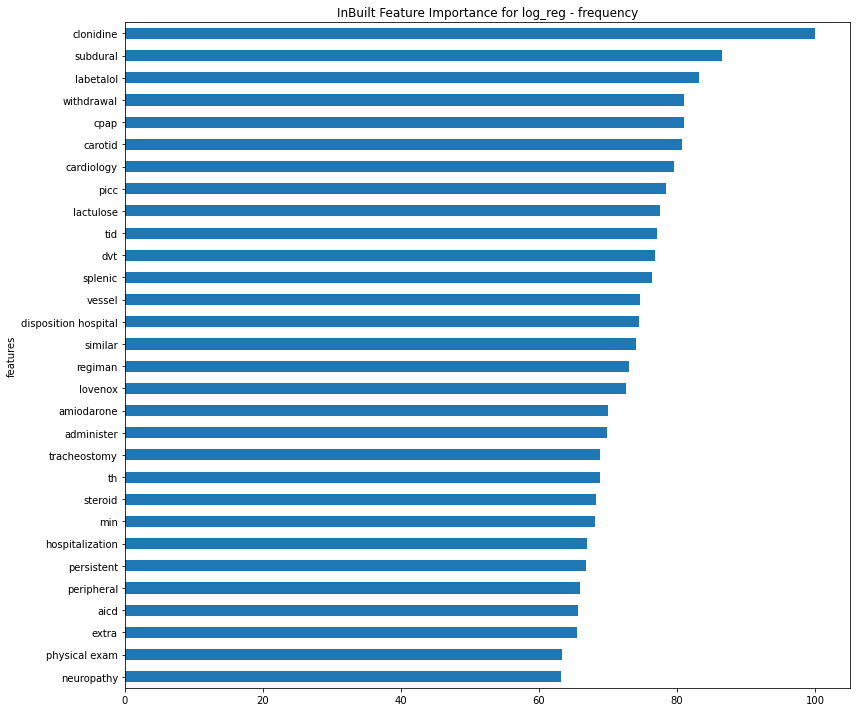

<Figure size 720x720 with 0 Axes>

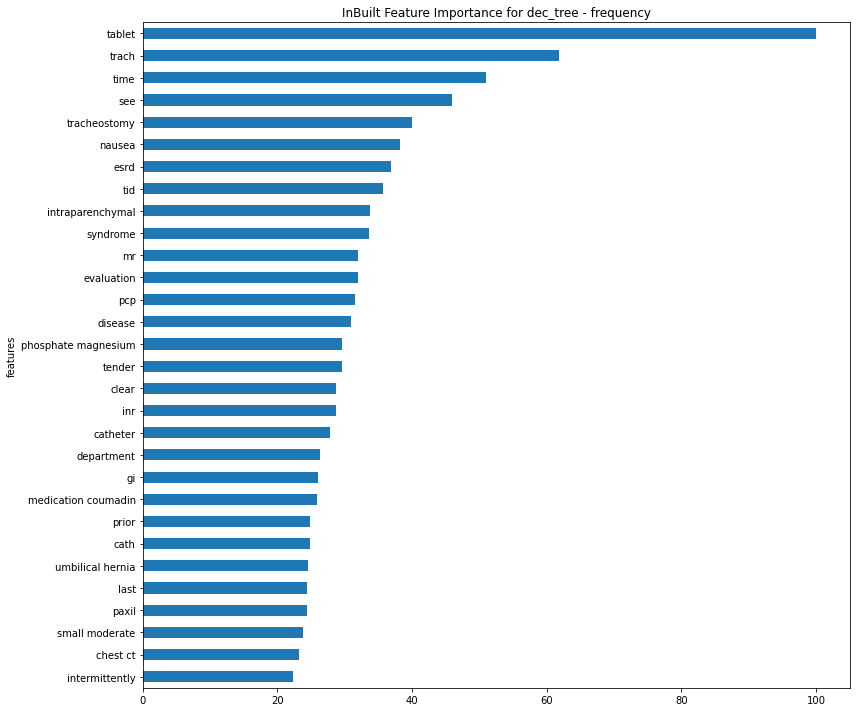

<Figure size 720x720 with 0 Axes>

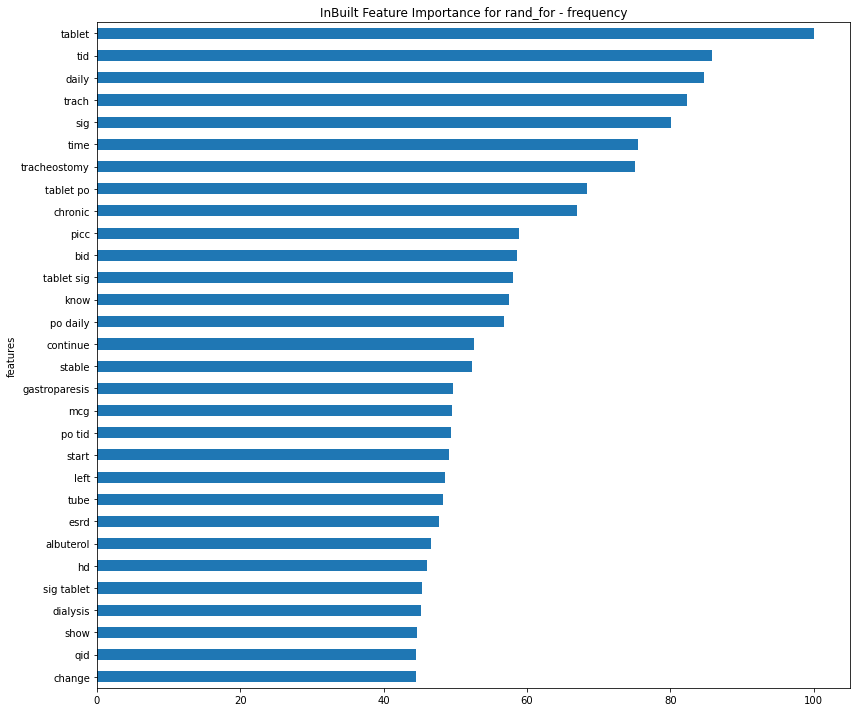

<Figure size 720x720 with 0 Axes>

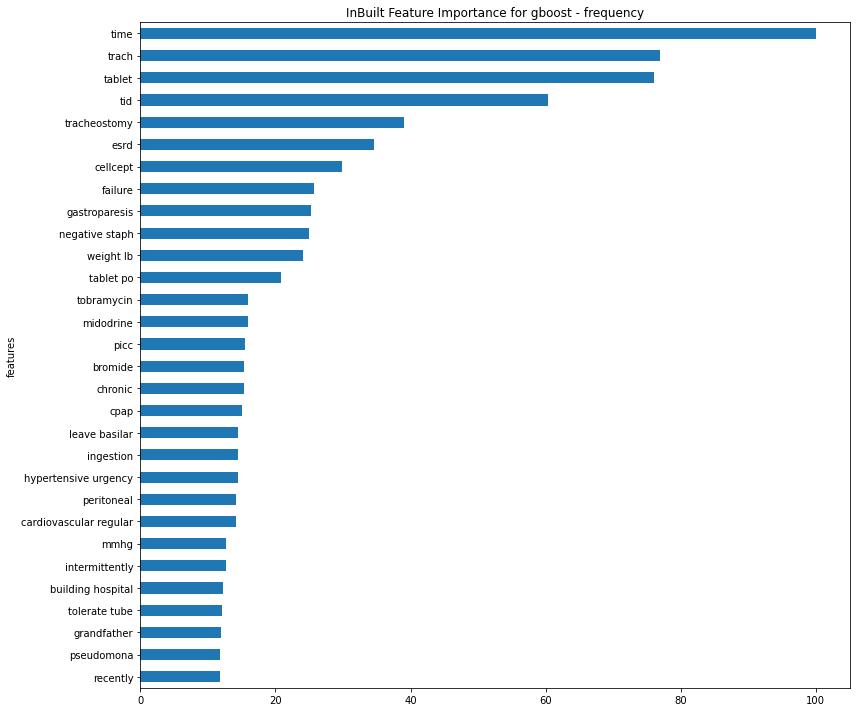

<Figure size 720x720 with 0 Axes>

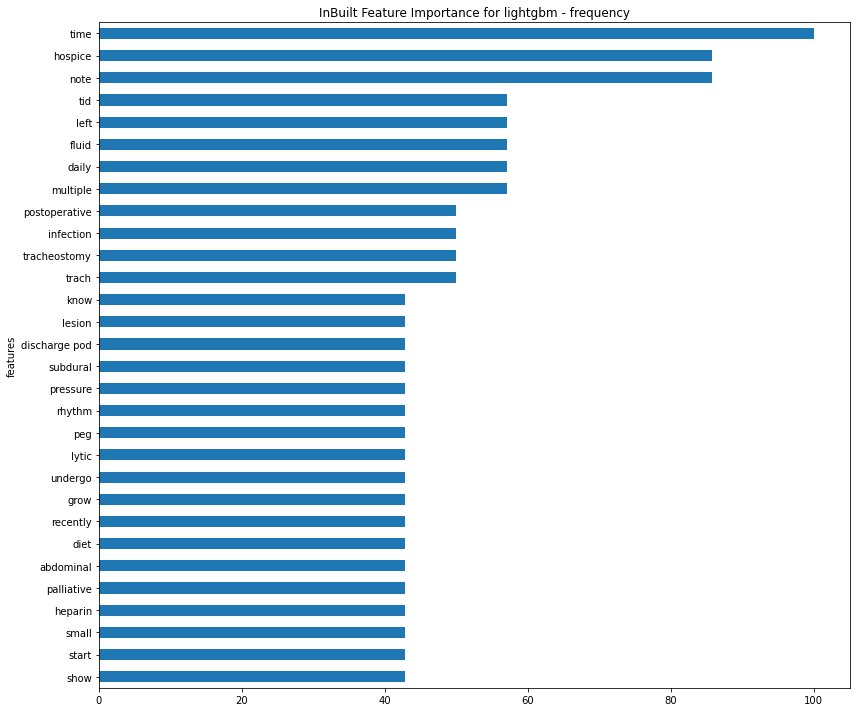

<Figure size 720x720 with 0 Axes>

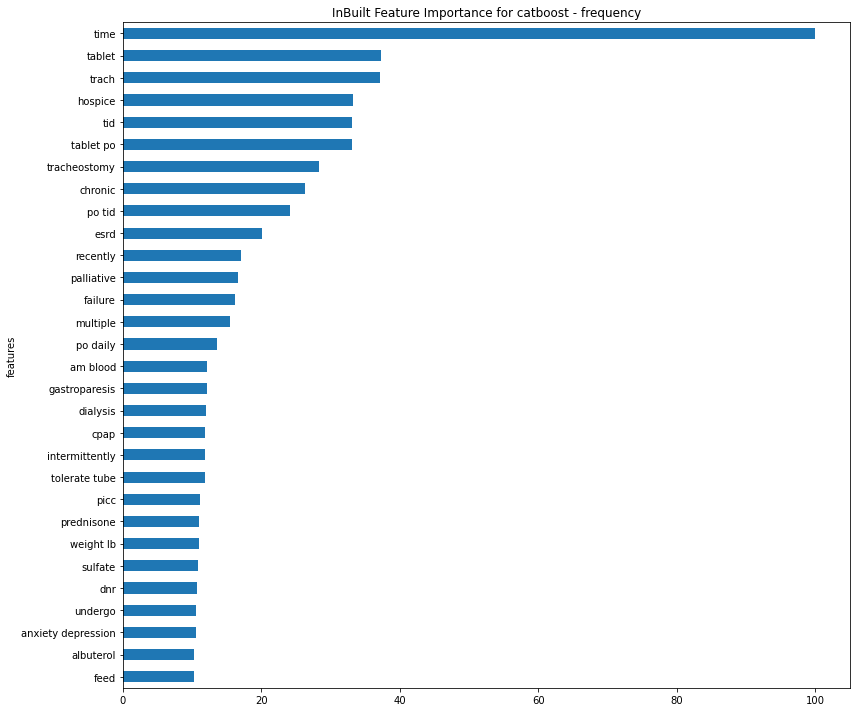

<Figure size 720x720 with 0 Axes>

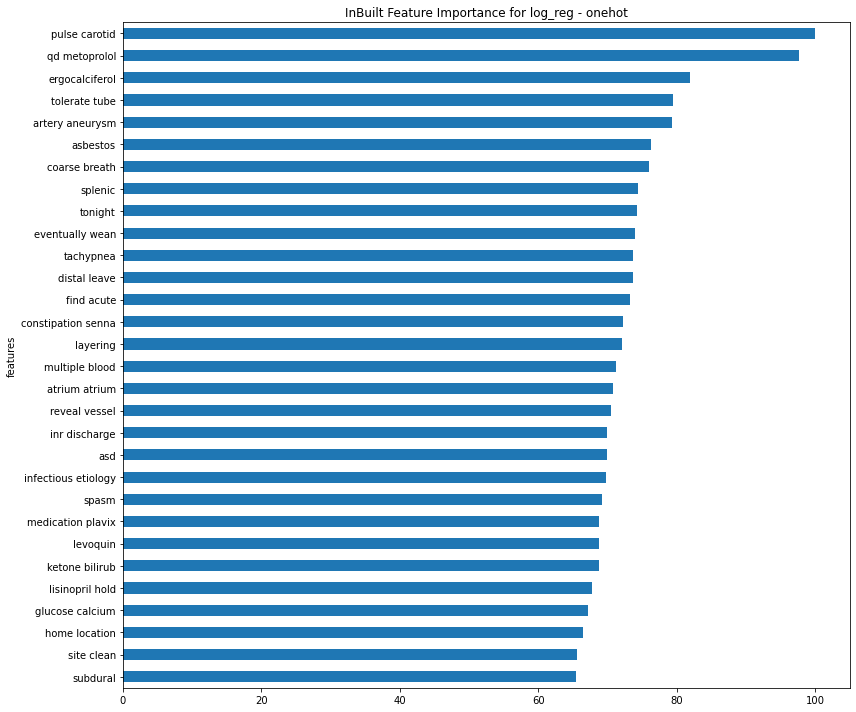

<Figure size 720x720 with 0 Axes>

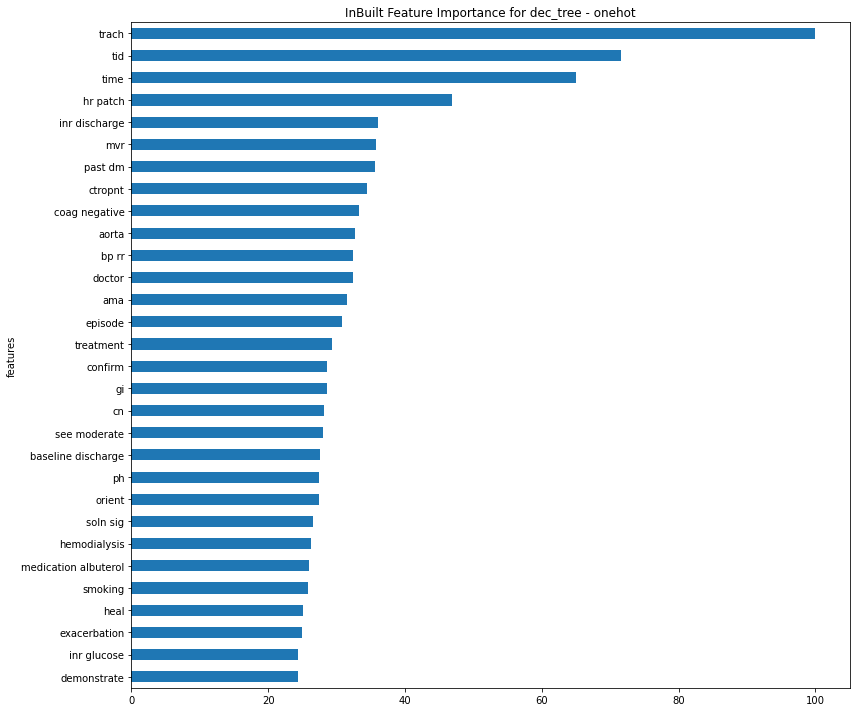

<Figure size 720x720 with 0 Axes>

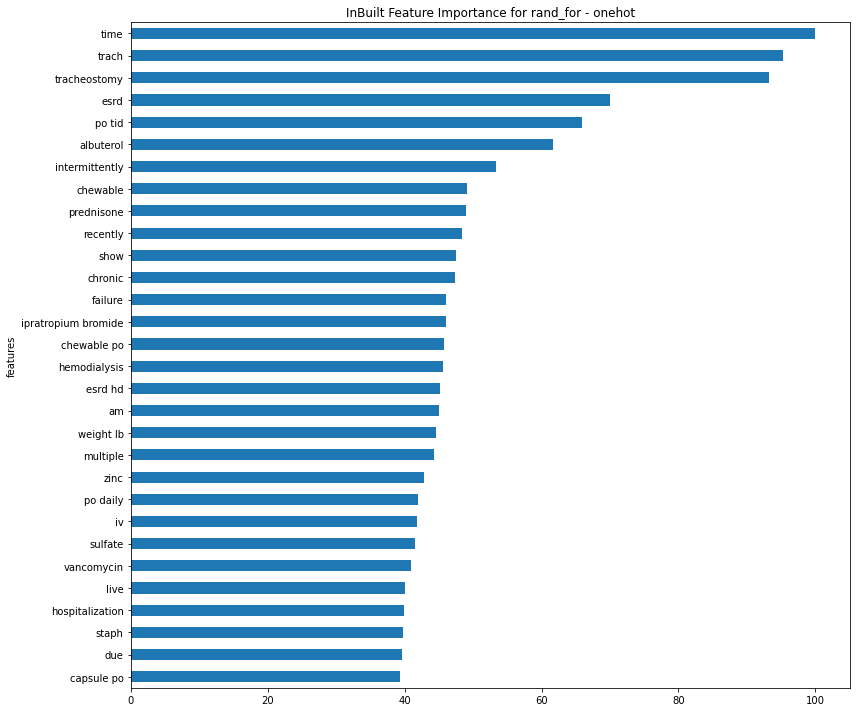

<Figure size 720x720 with 0 Axes>

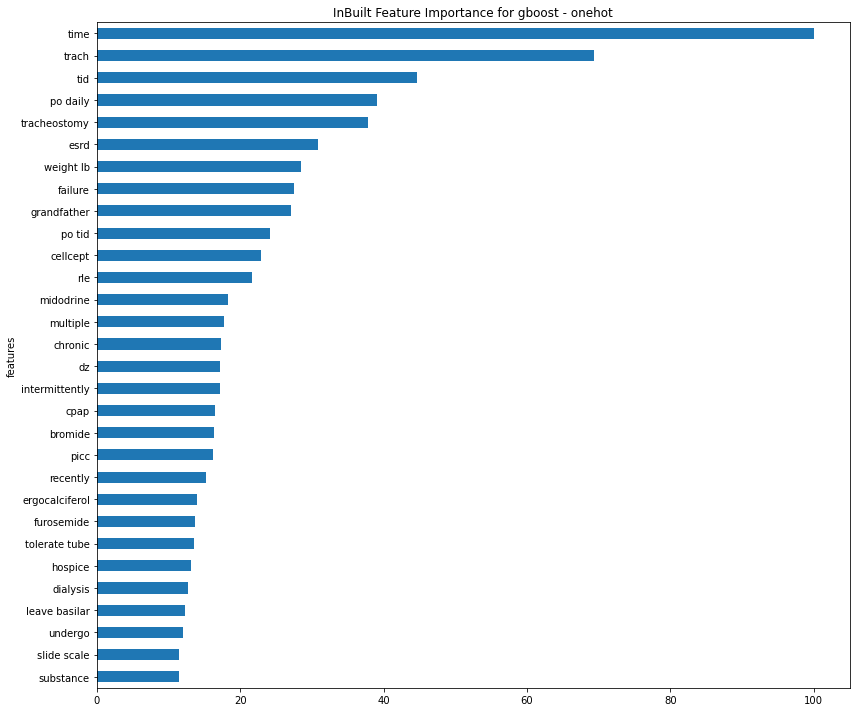

<Figure size 720x720 with 0 Axes>

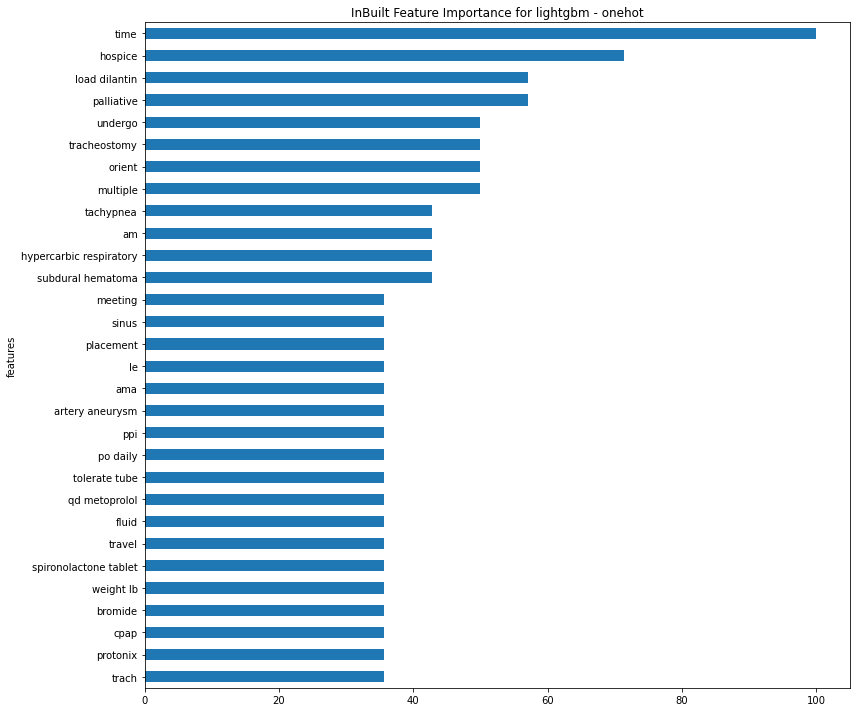

<Figure size 720x720 with 0 Axes>

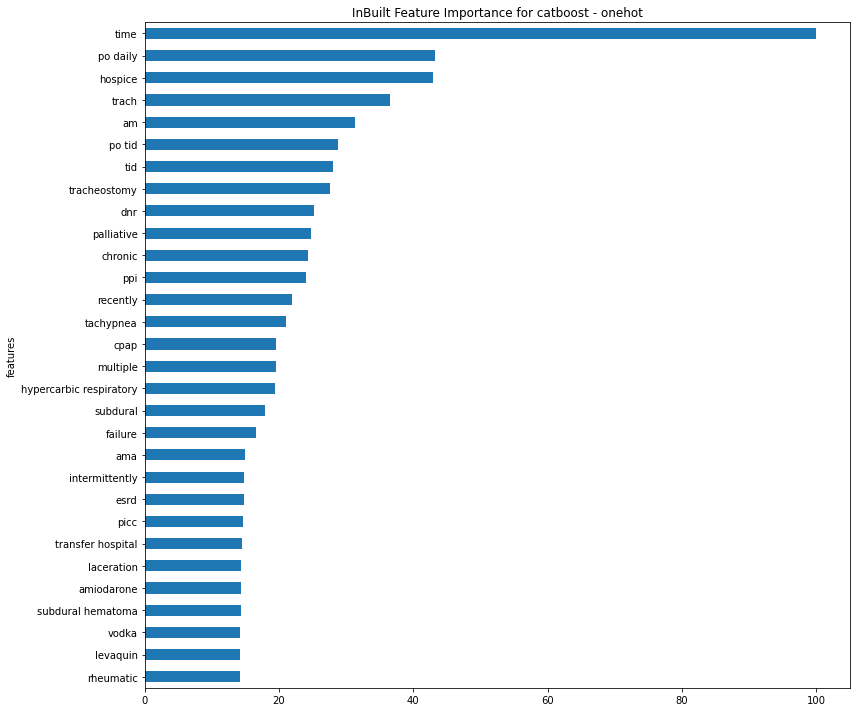

<Figure size 720x720 with 0 Axes>

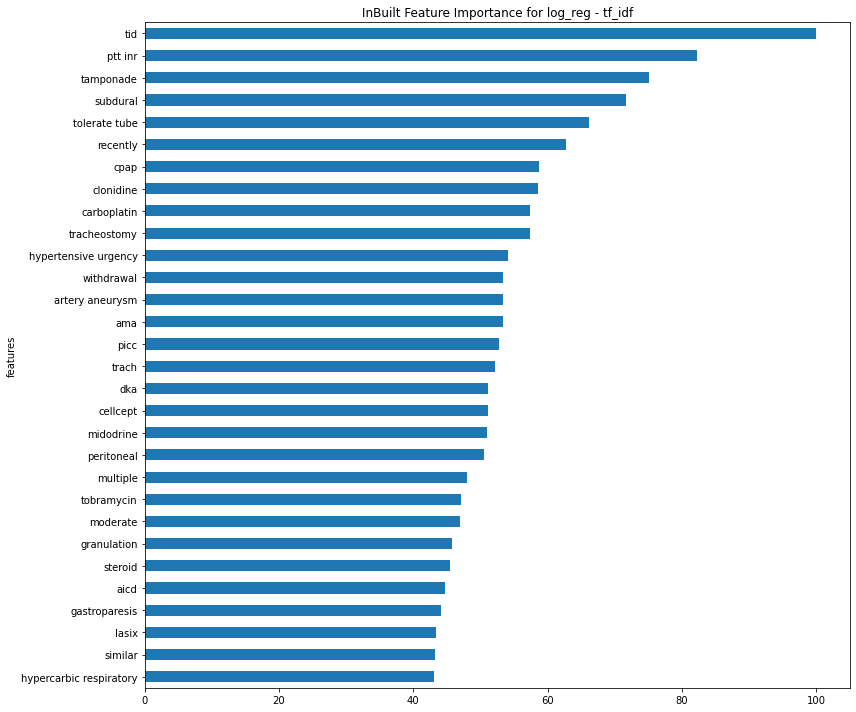

<Figure size 720x720 with 0 Axes>

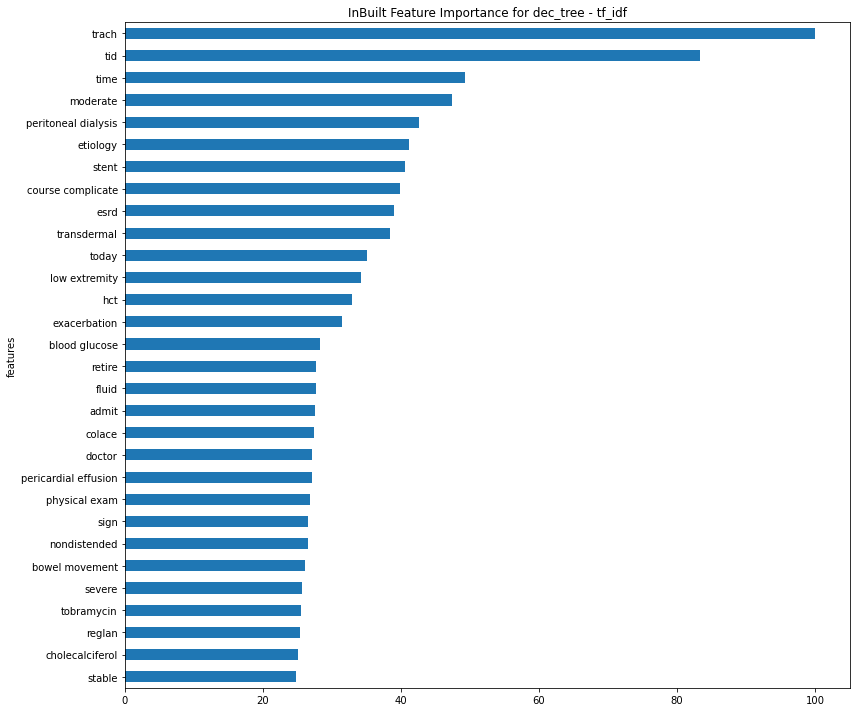

<Figure size 720x720 with 0 Axes>

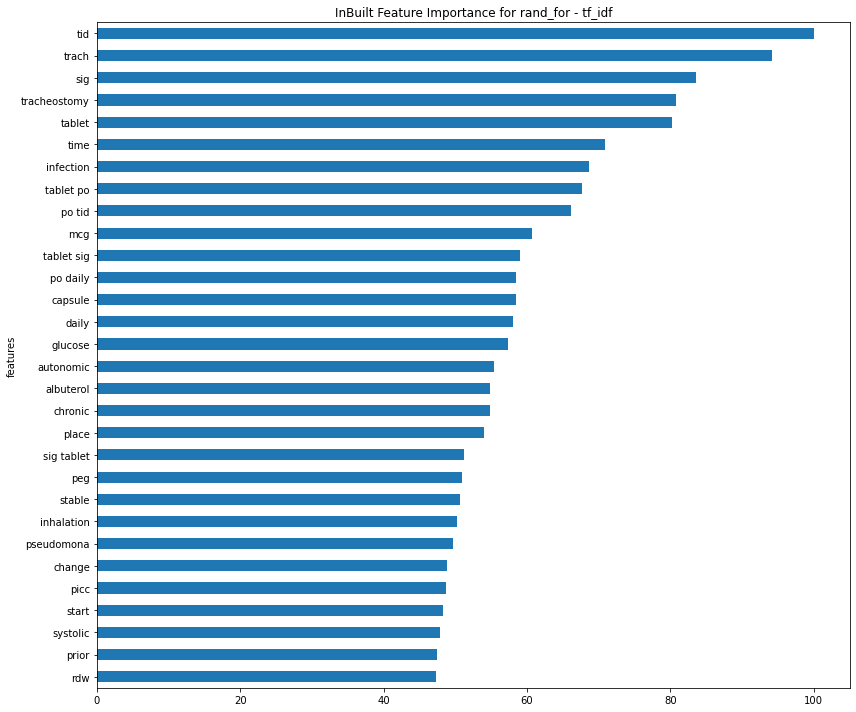

<Figure size 720x720 with 0 Axes>

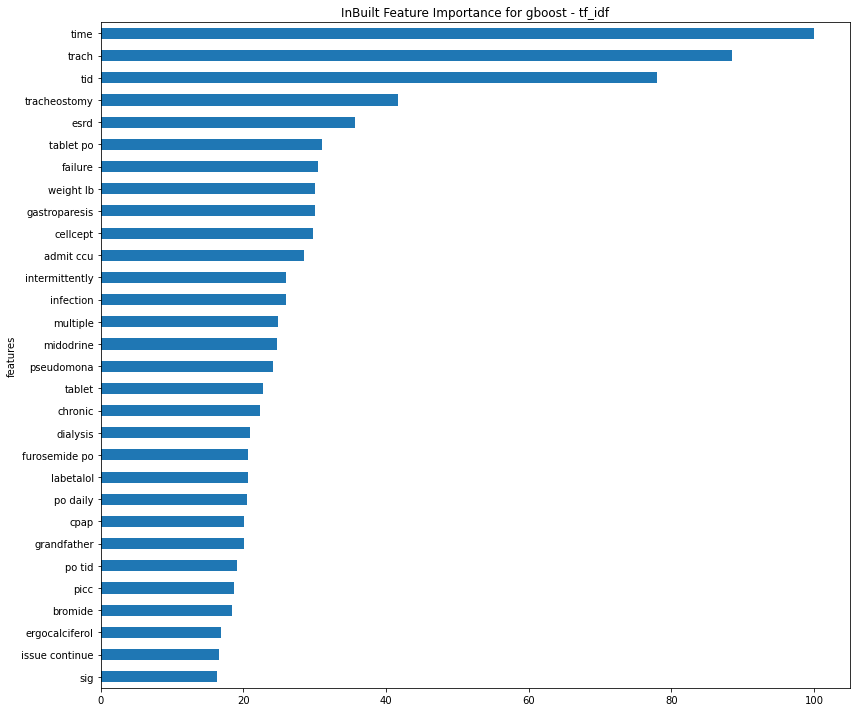

<Figure size 720x720 with 0 Axes>

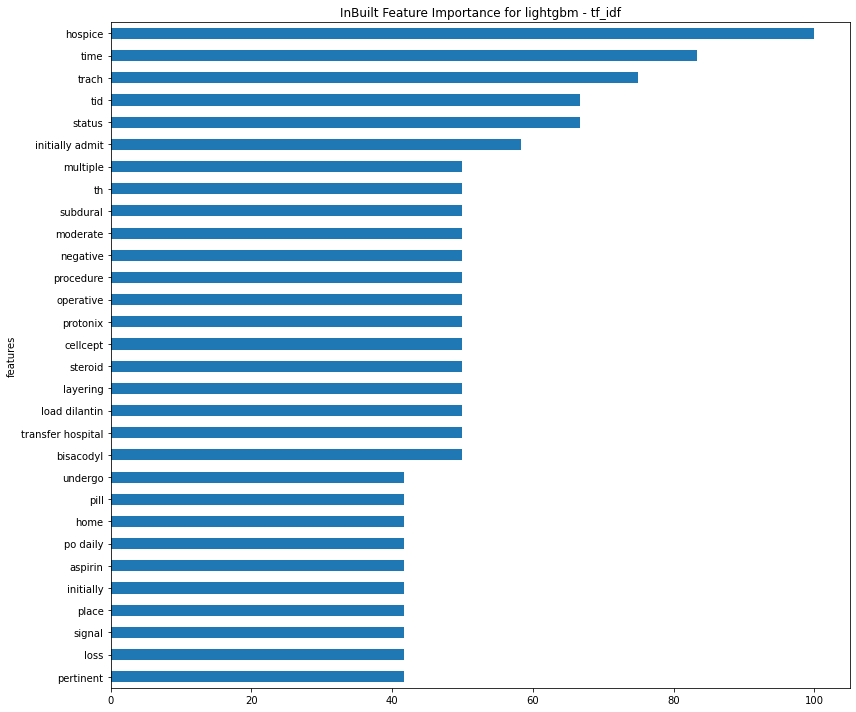

<Figure size 720x720 with 0 Axes>

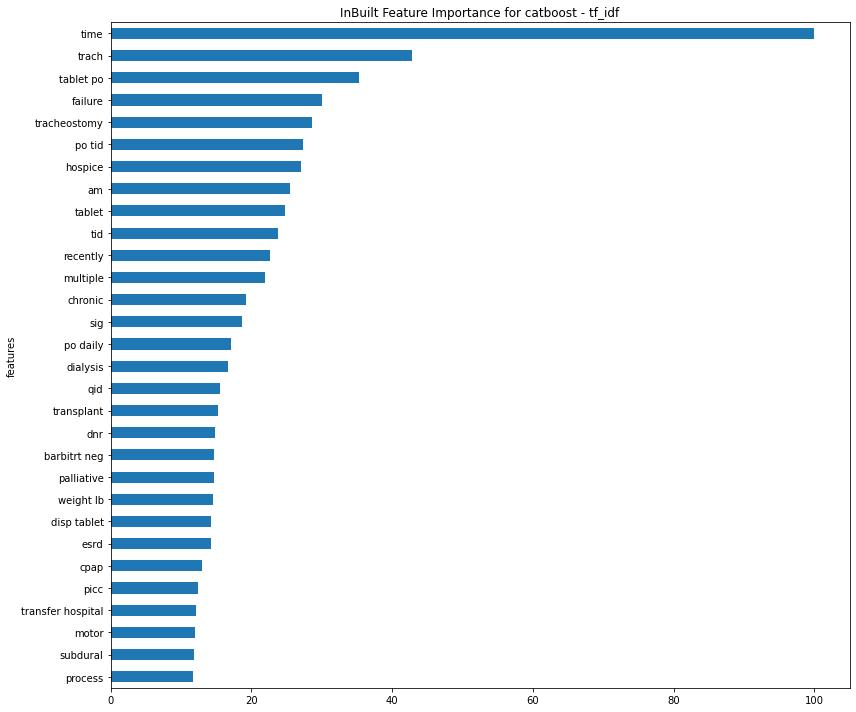

In [15]:
writer = pd.ExcelWriter(f'{path_to_models}output_feat.xlsx')
startrow = 0
for method in method_list:
    train, test, val = load_datasets(method, include_val = include_val) # we load the dataset we want to use
    for model_name in model_list:
        with open(f'{path_to_models}_{model_name}_{method}{tune_tag}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}{feat_tag}', 'rb') as file:
            estimator = dill.load(file)
            print('Model already trained')
        if model_name == 'log_reg':
            df_imp = df_perm_importance(test, estimator.coef_[0], inbuilt = True)
        else:
            df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
        plt.figure(figsize = (10,10))
        df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
        plt.title(f'InBuilt Feature Importance for {model_name} - {method}')
        save_fig(f'in_feat_imp_{method}_{model_name}{tune_tag}{med_tag}{heavier_tag}')
        df_imp[:30].to_excel(writer,sheet_name='Feat_Imp_Untuned', startrow=startrow +1)
        worksheet = writer.sheets['Feat_Imp_Untuned']
        worksheet.write(startrow, 0, f'{model_name} {method}')
        startrow += (df_imp[:30].shape[0] + 2)
        
writer.close()      

## Frequency

In [ ]:
method = 'frequency'
train, test, val = load_datasets(method, include_val = include_val)

### LightGBM

In [ ]:
model = 'log_reg'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.coef_[0], inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

### CatBoost

In [ ]:
model = 'catboost'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

## OneHot

In [ ]:
method = 'onehot'
train, test, val = load_datasets(method, include_val = include_val)

### Logistic Regression

In [ ]:
model = 'log_reg'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.coef_[0], inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

### LightGBM

In [ ]:
model = 'lightgbm'
tune_models = True

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

## TF-IDF

In [ ]:
method = 'tf_idf'
train, test, val = load_datasets(method, include_val = include_val)

### Random Forest

In [ ]:
model = 'log_reg'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.coef_[0], inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

### CatBoost

In [ ]:
model = 'catboost'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

## SVD

In [ ]:
method = 'svd'
train, test, val = load_datasets(method, include_val = include_val)

### GBoosting

In [ ]:
model = 'gboost'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

### LightGBM

In [ ]:
model = 'lightgbm'
tune_models = True

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

## LDA

In [ ]:
method = 'lda'
train, test, val = load_datasets(method, include_val = include_val)

### LightGBM

In [ ]:
model = 'lightgbm'
tune_models = True

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)

### CatBoost

In [ ]:
model = 'catboost'
tune_models = False

if tune_models:
  tune_tag = '_tuned'
else:
  tune_tag = ''

In [ ]:
with open(f'{path_to_models}_{model}_{method}{seed_tag}{lemma_tag}{med_tag}{heavier_tag}', 'rb') as file:
    estimator = dill.load(file)

In [ ]:
df_imp = df_perm_importance(test, estimator.feature_importances_, inbuilt = True)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'InBuilt Feature Importance for {model} - {method}')
save_fig(f'in_feat_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
try:
    with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'rb') as file:
        import_test = pickle.load(file)
    print('Importance loaded')
except:
    %time import_test = permutation_importance(estimator, test, y_test, n_jobs = -1, scoring = scoring, random_state = session_seed)

In [ ]:
df_imp = df_perm_importance(test, import_test)
plt.figure(figsize = (10,10))
df_imp[:30].plot(x="features", y="importance", kind="barh", figsize = (12,10), legend = False).invert_yaxis()
plt.title(f'Permuation Importance for {model} - {method}')
save_fig(f'perm_imp_{method}_{model}{med_tag}{heavier_tag}')

In [ ]:
# Then we save all our results
with open(f'{path_to_models}test_imp{model}{method}{lemma_tag}{med_tag}{heavier_tag}.pkl', 'wb') as file:
    pickle.dump(import_test, file)